In [1]:
# Previously read a readme about game rule and turn simulation used here.
# In this file I will use the information from player, challenge and simulation turn result 
# just as initial data to choose and train model
# So here we
# - Import and explore data
# - Get its ready for training
# - Explain criterion choice
# - Create pipeline to choose model
# - Make a gridsearch for best parameters
# - Train and save final model

In [2]:
# Importing the Libraries
import pandas as pd
import matplotlib.pyplot as plt 
import warnings
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

In [3]:
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
# Importing the self-written modules
from modules.data_simulation import InitialData

# Get a dataset with some combination of player cards and choosed challenge card with all 
# characteeristics and simulated answer if trying this challenge worth it or not.
# For details about simulation - module data_simulation - Turn - simulate_turn
data = InitialData()
turns = data.define_turns(6000, if_target=True)

In [5]:
# Main information about features. Happily don't have missing values
turns.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Игрок                6000 non-null   int64 
 1   Происхождение        6000 non-null   object
 2   Руна_1               6000 non-null   object
 3   Руна_2               6000 non-null   object
 4   Стремление           6000 non-null   object
 5   Опция                6000 non-null   object
 6   Судьба               6000 non-null   object
 7   Цель_1               6000 non-null   object
 8   Цель_2               6000 non-null   object
 9   Цель_3               6000 non-null   object
 10  Опыт                 6000 non-null   int64 
 11  Испытание            6000 non-null   object
 12  Основная руна        6000 non-null   object
 13  Дополнительная руна  6000 non-null   object
 14  Сложность            6000 non-null   int64 
 15  Стоит ли пробовать   6000 non-null   int64 
dtypes: int

In [6]:
# Example of how our information looks like. Most columns are categorical
turns.head()

,Игрок,Происхождение,Руна_1,Руна_2,Стремление,Опция,Судьба,Цель_1,Цель_2,Цель_3,Опыт,Испытание,Основная руна,Дополнительная руна,Сложность,Стоит ли пробовать
0,991,Поселенец,Телосложение,Интеллект,Связанный честью,Нет,Коварный злодей,Сила,Ловкость,Интеллект,0,Склонность к светлой магии,Интеллект,Обаяние,4,0
1,1288,Оруженосец,Ловкость,Сила,Избранник света,Нет,Карающая длань,Ловкость,Телосложение,Нет,1,Защитить родной дом,Телосложение,Сила,4,0
2,1791,Чужестранец,Телосложение,Мудрость,Ученик мастера,Сила,Коварный злодей,Сила,Ловкость,Интеллект,0,Познать темные тайны,Интеллект,Ловкость,4,0
3,1834,Чужестранец,Телосложение,Мудрость,Рожденный в рубашке,Нет,Народный заступник,Сила,Мудрость,Нет,1,Позаботиться о раненых,Мудрость,Телосложение,4,0
4,1947,Охотник,Мудрость,Ловкость,Сорвиголова,Ловкость,Великий завоеватель,Сила,Ловкость,Телосложение,0,"Украсть, чтобы выжить",Ловкость,Телосложение,4,0


<Axes: xlabel='Стоит ли пробовать', ylabel='count'>

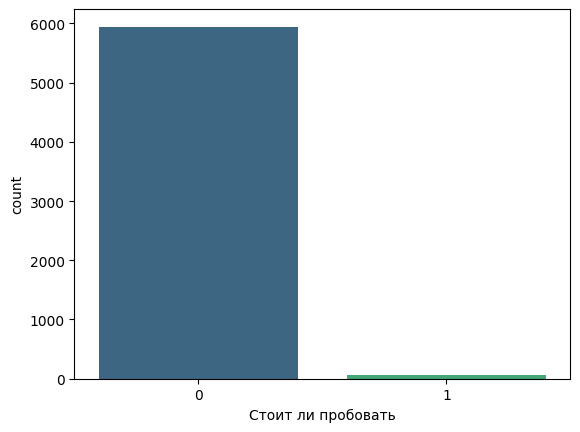

In [7]:
# Guess that we deal with unbalanced data - That's true! 
sns.countplot(data=turns, x='Стоит ли пробовать', palette='viridis')

In [8]:
# Don't have anything for cleaning data, because all our game turns are simulated. 
# For this purpose data were cleaned and explored before. Let's just explore them a bit 
# more not to go back and so we may know with what we are dealing

In [9]:
# With so unbalanced data, what we will see in positive outcome only
turns[turns['Стоит ли пробовать'] == 1][:10]

,Игрок,Происхождение,Руна_1,Руна_2,Стремление,Опция,Судьба,Цель_1,Цель_2,Цель_3,Опыт,Испытание,Основная руна,Дополнительная руна,Сложность,Стоит ли пробовать
137,1836,Чужестранец,Телосложение,Мудрость,Рожденный в рубашке,Нет,Великий завоеватель,Сила,Ловкость,Телосложение,1,Выжить в огне,Телосложение,Мудрость,3,1
156,134,Нищий,Ловкость,Обаяние,Избранник света,Нет,Дитя природы,Мудрость,Сила,Обаяние,1,Выучиться на шпиона,Обаяние,Ловкость,3,1
373,308,Музыкант,Обаяние,Телосложение,Поклявшийся защишать,Телосложение,Бесстрашный первооткрыватель,Телосложение,Интеллект,Нет,1,Усмирить грабителя,Обаяние,Телосложение,3,1
394,418,Музыкант,Обаяние,Телосложение,Избранник света,Нет,Драконорожденный,Телосложение,Обаяние,Нет,1,Усмирить грабителя,Обаяние,Телосложение,3,1
472,294,Музыкант,Обаяние,Телосложение,В поисках истины,Мудрость,Дитя природы,Мудрость,Сила,Обаяние,1,Изгнать призрака,Мудрость,Обаяние,3,1
555,152,Послушник,Мудрость,Обаяние,В поисках истины,Мудрость,Карающая длань,Ловкость,Телосложение,Нет,1,Скрыться от преследователей,Ловкость,Мудрость,3,1
987,454,Торговец,Интеллект,Обаяние,Поклявшийся защишать,Телосложение,Дитя природы,Мудрость,Сила,Обаяние,1,Усмирить грабителя,Обаяние,Телосложение,3,1
1156,357,Музыкант,Обаяние,Телосложение,Сорвиголова,Ловкость,Дитя природы,Мудрость,Сила,Обаяние,0,Усмирить грабителя,Обаяние,Телосложение,3,1
1203,1768,Чужестранец,Телосложение,Мудрость,Прирожденный лидер,Обаяние,Карающая длань,Ловкость,Телосложение,Нет,1,Выжить в огне,Телосложение,Мудрость,3,1
1211,1300,Новобранец,Сила,Телосложение,В поисках истины,Мудрость,Бесстрашный первооткрыватель,Телосложение,Интеллект,Нет,1,Выжить в огне,Телосложение,Мудрость,3,1


In [10]:
# For some rows any of cards and its characteristics are the same. Its have diffenece 
# in column Опыт, but this doesn't affect the result. Let's look at this a bit closer

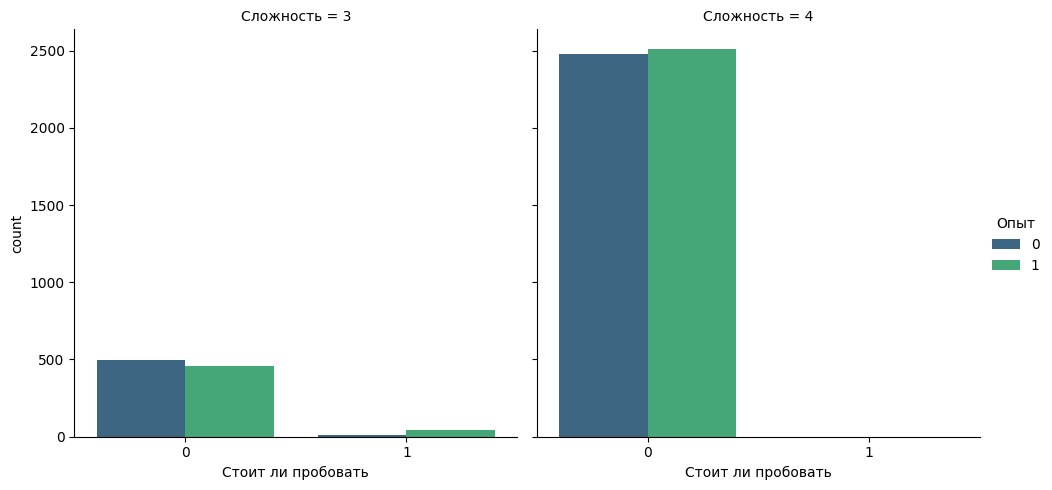

In [11]:
# Have only two numeric data, let's watch how its influence on target
sns.catplot(data=turns, x='Стоит ли пробовать', hue='Опыт', col='Сложность', kind='count', palette='viridis')
plt.show()

<Axes: xlabel='Сложность', ylabel='count'>

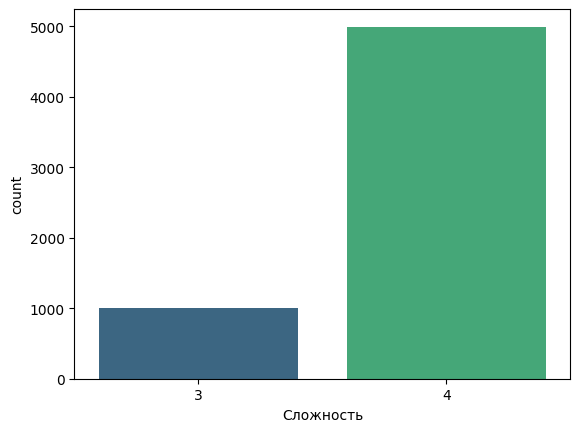

In [12]:
# Actually, do challenges with complexity(сложность) 4 are more often than with complexity 3?
# Yes! 
sns.countplot(data=turns, x='Сложность', palette='viridis')

In [13]:
# So, looking in previous graph. With more complexity it becomes less worth to take 
# the risky challenge, but experience become more helpful. Sounds logical

In [14]:
# Let's explore runes (руны)
turns['Руна_1'].unique()

array(['Телосложение', 'Ловкость', 'Мудрость', 'Сила', 'Интеллект',
       'Обаяние'], dtype=object)

In [15]:
turns['Руна_2'].unique()

array(['Интеллект', 'Сила', 'Мудрость', 'Ловкость', 'Телосложение',
       'Обаяние'], dtype=object)

In [16]:
turns['Основная руна'].value_counts()

Основная руна
Обаяние         1062
Сила            1013
Телосложение     999
Мудрость         992
Интеллект        970
Ловкость         964
Name: count, dtype: int64

In [17]:
# So we have in sum 6 runes ain near the same quantity

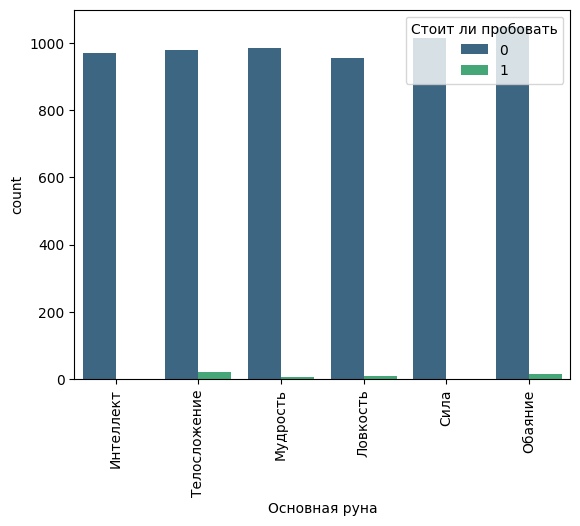

In [18]:
# With some of them challenges are simplier to take
sns.countplot(data=turns, x= 'Основная руна', hue = 'Стоит ли пробовать', palette='viridis')
plt.xticks(rotation=90);
plt.show()

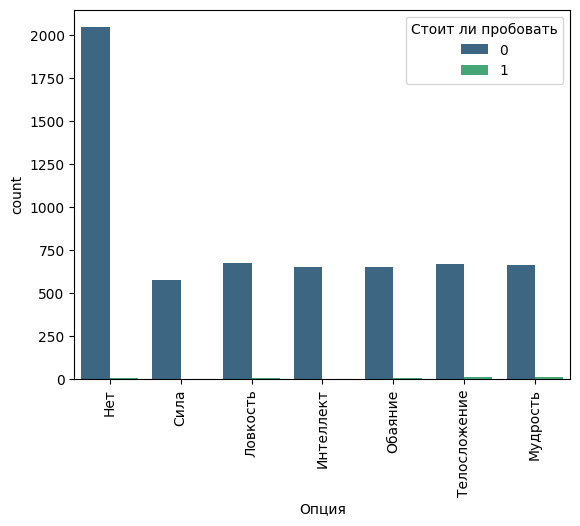

In [19]:
# Also we have 'Нет' option in category 'Опция'. But looks like it doesn't affect results much,
# positive result for this category bigger just because this category bigger itself
sns.countplot(data=turns, x= 'Опция', hue = 'Стоит ли пробовать', palette='viridis')
plt.xticks(rotation=90);
plt.show()

In [20]:
# Data preprocessing
# Create list of categorical features and the main features that are different for every row, just contains some card names
features_cat = ["Руна_1", "Руна_2", "Опция", "Цель_1", "Цель_2", "Цель_3", "Основная руна", "Дополнительная руна"]
drops = ["Игрок", "Испытание", "Стоит ли пробовать", "Происхождение", "Стремление", "Судьба"]

In [21]:
# The following steps are involved:
# - Building dummies for the categorical columns
# - Assigning labels and targets
# - Lastly, splitting the test and training sets

In [22]:
# Creating dummy variables and deleting the previous column
for i in features_cat:
    turns[i] = turns[i].astype("category")
    dummy_df = pd.get_dummies(turns[i], prefix=i, drop_first=True, dtype=int)
    turns = pd.concat([turns, dummy_df], axis=1)
    turns = turns.drop(i, axis=1)
    
for i in ["Опыт", "Сложность","Стоит ли пробовать"]:
    turns[i] = turns[i].astype(int)
    
X = turns.drop(drops, axis=1)
y = turns["Стоит ли пробовать"]

In [23]:
# Closer look on features now
X.head()

,Опыт,Сложность,Руна_1_Ловкость,Руна_1_Мудрость,Руна_1_Обаяние,Руна_1_Сила,Руна_1_Телосложение,Руна_2_Ловкость,Руна_2_Мудрость,Руна_2_Обаяние,...,Основная руна_Ловкость,Основная руна_Мудрость,Основная руна_Обаяние,Основная руна_Сила,Основная руна_Телосложение,Дополнительная руна_Ловкость,Дополнительная руна_Мудрость,Дополнительная руна_Обаяние,Дополнительная руна_Сила,Дополнительная руна_Телосложение
0,0,4,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,1,4,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
2,0,4,0,0,0,0,1,0,1,0,...,0,0,0,0,0,1,0,0,0,0
3,1,4,0,0,0,0,1,0,1,0,...,0,1,0,0,0,0,0,0,0,1
4,0,4,0,1,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,1


In [24]:
X_trains, X_valid, y_trains, y_valid = train_test_split(X, y, test_size=0.10, random_state=101)

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X_trains, y_trains, test_size=0.20, random_state=101)

In [26]:
X_train

,Опыт,Сложность,Руна_1_Ловкость,Руна_1_Мудрость,Руна_1_Обаяние,Руна_1_Сила,Руна_1_Телосложение,Руна_2_Ловкость,Руна_2_Мудрость,Руна_2_Обаяние,...,Основная руна_Ловкость,Основная руна_Мудрость,Основная руна_Обаяние,Основная руна_Сила,Основная руна_Телосложение,Дополнительная руна_Ловкость,Дополнительная руна_Мудрость,Дополнительная руна_Обаяние,Дополнительная руна_Сила,Дополнительная руна_Телосложение
1523,0,4,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
3486,1,4,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
1588,0,4,0,1,0,0,0,1,0,0,...,0,0,0,1,0,0,0,1,0,0
2120,1,3,0,1,0,0,0,1,0,0,...,0,0,1,0,0,1,0,0,0,0
3400,0,4,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4845,1,4,0,0,0,0,1,0,0,0,...,0,1,0,0,0,1,0,0,0,0
1550,0,4,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2822,1,3,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
4738,1,4,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1


In [27]:
# Model selection
# My main was to use the second data division(_train and _test) for testing different model, 
# than use _trains for gridsearchCV for best parameters for one choosed model
# So will create pipeline for some model and see how it works
## Remember that we have unbalanced data ##

In [28]:
# Building pipelines for model selection

pipeline_lr=Pipeline([("scaler1",StandardScaler()),
                      ("LR",LogisticRegressionCV(class_weight='balanced'))])

pipeline_rf=Pipeline([("scaler2",StandardScaler()),
                      ("RF",RandomForestClassifier(random_state=42, class_weight='balanced'))])

pipeline_knn=Pipeline([("scaler3",StandardScaler()),
                       ("KNN",KNeighborsClassifier(n_neighbors=5, weights='distance'))])

pipeline_xgb=Pipeline([("scaler4",StandardScaler()),
                       ("XGB",XGBClassifier(scale_pos_weight = (y == 0).sum() / (y == 1).sum()))])

# List of all the pipelines
pipelines = [pipeline_lr, pipeline_rf, pipeline_knn, pipeline_xgb]
pipe_dict = {0: "LinearRegression", 1: "RandomForest", 2: "KNeighbors", 3: "XGBRegressor"}

In [29]:
for pipe in pipelines:
    pipe.fit(X_train, y_train)
    
results = []
for i, model in enumerate(pipelines):
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    results.append(f1)
    print("%s: %f " % (pipe_dict[i], f1))

# I choosed f1-score as a parameter to balance between precision and recall, so to maximize
# chance that you will not take some realy risk challenge, but at the same time not miss a simple one
# Gradient boosting shows a better performance than other models, so will do gridsearch for it

c:\Users\kotikovacat\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\kotikovacat\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-

LinearRegression: 0.119048 
RandomForest: 0.750000 
KNeighbors: 0.500000 
XGBRegressor: 0.769231 


In [30]:
# Scale our first data division
scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_trains)
scaled_X_test = scaler.transform(X_valid)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}

# Initialize the XGBoost classifier
xgb = XGBClassifier(objective='binary:logistic', random_state=42, eval_metric='logloss', 
                    scale_pos_weight = (y == 0).sum() / (y == 1).sum())

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='roc_auc',  # Use 'roc_auc' for imbalanced datasets
    cv=5,  
    n_jobs=-1,  
    verbose=2
)

# Fit the model
grid_search.fit(X_trains, y_trains)

# Best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Parameters: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 100}
Best Score: 0.9841857039111941


In [31]:
y_pred = grid_search.predict(X_valid)
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       593
           1       0.60      0.43      0.50         7

    accuracy                           0.99       600
   macro avg       0.80      0.71      0.75       600
weighted avg       0.99      0.99      0.99       600



In [32]:
# Create and train final version of model
final_model = XGBClassifier(learning_rate=0.2, max_depth=7, n_estimators=200,
                           objective='binary:logistic', random_state=42, 
                           eval_metric='logloss', scale_pos_weight = (y == 0).sum() / (y == 1).sum())
final_model.fit(X, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.2, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [33]:
# Save final version of our model 
final_model.save_model("xgboost_model.json")

In [34]:
# Look another file to find a usage of this model) 